In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Loading Dataset

In [2]:
df = pd.read_csv("winequality-red.csv", sep=";")


In [3]:
df["quality"].value_counts()

quality
5    681
6    638
7    199
4     53
8     18
3     10
Name: count, dtype: int64

In [4]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [5]:
df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

# Making label in 0 and 1 form

In [6]:
df['quality'] = df['quality'].apply(lambda x: 0 if x <= 6 else 1)

# Min-max normalization for all other columns

In [7]:

features = df.columns.drop('quality')  # all columns except quality

for col in features:
    min_val = df[col].min()
    max_val = df[col].max()
    df[col] = (df[col] - min_val) / (max_val - min_val)


In [8]:
# -------------------------
# 4. Split features and labels
# -------------------------
X = df[features].values    # numpy array of shape (m, n)
y = df['quality'].values   # numpy array of shape (m,)


# Sigmoid function

In [9]:

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Logistic Regression using Gradient Descent

In [10]:

def logistic_regression(X, y, lr=0.1, epochs=5000):
   
    m, n = X.shape
    W = np.zeros(n)    
    b = 0.0            

    for _ in range(epochs):
        z = X @ W + b          
        y_pred = sigmoid(z)    

        dw = (1/m) * (X.T @ (y_pred - y))
        db = (1/m) * np.sum(y_pred - y)

        W -= lr * dw
        b -= lr * db

    return W, b # Returning weights and bias

# Prediction function

In [11]:

def predict(X, W, b, threshold=0.5):
    probs = sigmoid(X @ W + b)
    return (probs >= threshold).astype(int)

# Train Test Split

In [12]:
def train_test_split_manual(X, y, test_size=0.2, seed=42):
    np.random.seed(seed)
    m = X.shape[0]
    indices = np.arange(m)
    np.random.shuffle(indices)

    test_count = int(m * test_size)

    test_idx = indices[:test_count]
    train_idx = indices[test_count:]

    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]


X_train, X_test, y_train, y_test = train_test_split_manual(X, y, test_size=0.2)

# Model Training

In [13]:

W, b = logistic_regression(X_train, y_train, lr=0.1, epochs=5000)

# Metrics: Accuracy, Precision, Recall

In [14]:

def evaluate_metrics(y_true, y_pred):
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))

    accuracy = (TP + TN) / len(y_true)
    precision = TP / (TP + FP + 1e-10)  # avoid division by zero
    recall = TP / (TP + FN + 1e-10)

    return accuracy, precision, recall

# Predictions

In [15]:

y_train_pred = predict(X_train, W, b)
y_test_pred  = predict(X_test, W, b)

# Evaluate

In [16]:

train_acc, train_prec, train_rec = evaluate_metrics(y_train, y_train_pred)
test_acc, test_prec, test_rec = evaluate_metrics(y_test, y_test_pred)

print("Training Performance:")
print(f"Accuracy : {train_acc:.4f}, Precision : {train_prec:.4f}, Recall : {train_rec:.4f}")

print("\nTesting Performance:")
print(f"Accuracy : {test_acc:.4f}, Precision : {test_prec:.4f}, Recall : {test_rec:.4f}")

Training Performance:
Accuracy : 0.8742, Precision : 0.5882, Recall : 0.1765

Testing Performance:
Accuracy : 0.8558, Precision : 0.5333, Recall : 0.1702


# Checking using Skikit-Learn

In [17]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [18]:

X = df.drop('quality', axis=1).values
y = df['quality'].values

In [19]:

from sklearn.linear_model import LogisticRegression

# Use very large C to approximate no regularization
clf_sklearn = LogisticRegression(
    penalty=None,     # use No penalty
    C=1e12,           
    solver='saga',
    max_iter=5000
)

# 3-fold cross-validation

In [20]:

kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Store metrics
sklearn_acc = []
sklearn_prec = []
sklearn_rec = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Train classifier
    clf_sklearn.fit(X_train, y_train)
    
    # Predict
    y_pred = clf_sklearn.predict(X_test)
    
    # Evaluate metrics for class 1 ("good")
    sklearn_acc.append(accuracy_score(y_test, y_pred))
    sklearn_prec.append(precision_score(y_test, y_pred, pos_label=1))
    sklearn_rec.append(recall_score(y_test, y_pred, pos_label=1))

# mean metrics

In [21]:

print("Scikit-learn Logistic Regression (saga, no penalty) 3-fold CV:")
print(f"Mean Accuracy : {np.mean(sklearn_acc):.4f}")
print(f"Mean Precision: {np.mean(sklearn_prec):.4f}")
print(f"Mean Recall   : {np.mean(sklearn_rec):.4f}")

Scikit-learn Logistic Regression (saga, no penalty) 3-fold CV:
Mean Accuracy : 0.8768
Mean Precision: 0.5855
Mean Recall   : 0.3176


# Plotting Metrics per fold

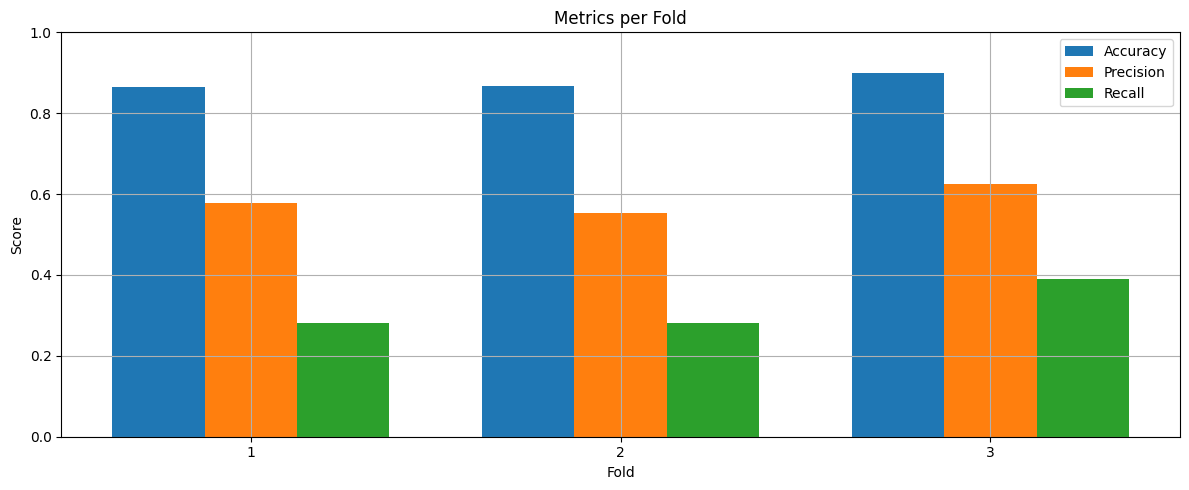

In [22]:

folds = np.arange(1, len(sklearn_acc) + 1)

plt.figure(figsize=(12, 5))


width = 0.25
plt.bar(folds - width, sklearn_acc, width=width, label="Accuracy")
plt.bar(folds, sklearn_prec, width=width, label="Precision")
plt.bar(folds + width, sklearn_rec, width=width, label="Recall")
plt.xticks(folds)
plt.xlabel("Fold")
plt.ylabel("Score")
plt.title("Metrics per Fold")
plt.ylim(0,1)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()